### Preámbulo de paquetes a utilizarse

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

### Carga de datos de penetracion BAF y municipios

In [2]:
data = pd.read_csv ('BAF_06209_selected.csv')

# Elimina columas
del data['SATELITAL']
del data['TERRESTRE_FIJO_INALAMBRICO']
del data['OTRAS_TECNOLOGIAS']
del data['SIN_TECNOLOGIA_ESPECIFICADA']
del data['CABLE_COAXIAL']
del data['DSL']
del data['FIBRA_OPTICA']
del data['COAX_FO']
del data['ALL_ACCESS']
del data['PEN_BAF']
del data['PEN_BAF_COAXFO']


# Eliminia indices de base Naciones Unidas y CONAPO
del data['INDICE_DE_EDUCACION']
del data['INDICE_DE_SALUD']
del data['INDICE_DE_INGRESO']
del data['IDH']
del data['IM']
del data['TASA_DE_MORTALIDAD_INFANTIL']
del data['OVSDE']
del data['OVSEE']
del data['OVSAE']
del data['VHAC']


del data['ANOS_ESPERADOS_DE_ESCOLARIZACIÓN']

# Renombramos una columna para que no de problemas
data.rename(columns={"PL<5000": "PL5000"}, inplace=True)

#del data['HOGARES'] # hogares de los municipios
#del data['POBLACION'] # hogares de los municipios
del data['SUPERFICIE'] # superficie de municipios
#del data['ALL_ACCESS'] # numero total de accesos BAF

# Sustitumos valores de la columnas NUM_OPS (1= Hay mas de dos operadores, 0 = en otro caso)
data['NUM_OPS'] = np.where(data['NUM_OPS']>1,1,0)

#data["PEN_CLASS"] = data["PEN_CLASS"].astype('category')

data.dropna(inplace=True)

data.describe()

,HOGARES,POBLACION,ANALF,SPRIM,OVPT,PL5000,PO2SM,DISP_INTERNET,DISP_TV_PAGA,DISP_TEL_CELULAR,DISP_TEL_FIJO,NUM_OPS,DENS_HOGS,ANOS_PROMEDIO_DE_ESCOLARIDAD,INGRESOPC_ANUAL,PEN_CLASS
count,2446.000000,2.446000e+03,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000
mean,12991.372036,4.860599e+04,11.690286,29.213050,8.289027,71.898684,55.381063,12.054015,31.158202,57.439859,20.204734,0.226492,7916.018110,6.423426,1935.145724,0.487326
std,38143.144359,1.389142e+05,8.527067,11.862555,8.879405,34.685724,16.985484,12.770534,18.829657,25.072398,14.044259,0.418647,35001.243252,1.767869,1020.473455,0.861612
min,31.000000,8.700000e+01,0.670000,2.490000,0.000000,0.000000,8.250000,0.000000,0.000000,0.000000,0.000000,0.000000,4.995331,1.460000,185.290000,0.000000
25%,1111.750000,4.253000e+03,5.240000,20.500000,1.882500,42.687500,42.930000,2.100553,15.313693,42.198730,9.047367,0.000000,521.867640,5.190000,1198.730000,0.000000
50%,3471.500000,1.340400e+04,9.725000,29.405000,5.215000,100.000000,57.020000,7.954121,29.018092,64.877177,17.645177,0.000000,1387.721595,6.280000,1789.905000,0.000000
75%,8877.500000,3.439950e+04,15.705000,37.345000,11.377500,100.000000,68.470000,17.788759,45.173174,76.445478,29.454433,0.000000,3462.189955,7.520000,2447.497500,1.000000
max,495665.000000,1.827868e+06,56.420000,71.240000,68.490000,100.000000,94.120000,81.882586,85.097192,95.002027,84.047612,1.000000,598127.340824,13.830000,9748.530000,5.000000


In [4]:
sz = data.shape
m,n = sz
m
list(data.columns.values)

#plt.scatter(data['HOGARES'], data['DISP_INTERNET'], c=data['PEN_CLASS'], alpha=0.5)
#plt.xlabel("Hogares"); plt.ylabel("% Disponibilidad internet");

['HOGARES',
 'POBLACION',
 'ANALF',
 'SPRIM',
 'OVPT',
 'PL5000',
 'PO2SM',
 'DISP_INTERNET',
 'DISP_TV_PAGA',
 'DISP_TEL_CELULAR',
 'DISP_TEL_FIJO',
 'NUM_OPS',
 'DENS_HOGS',
 'ANOS_PROMEDIO_DE_ESCOLARIDAD',
 'INGRESOPC_ANUAL',
 'PEN_CLASS']

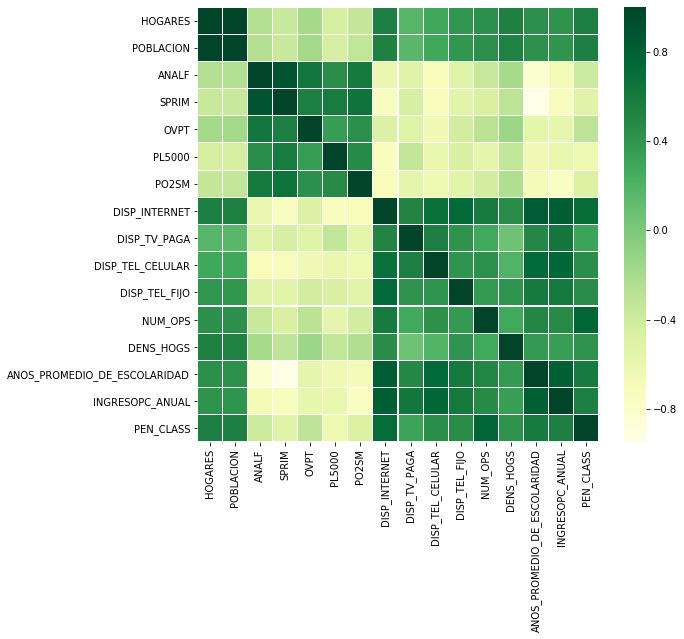

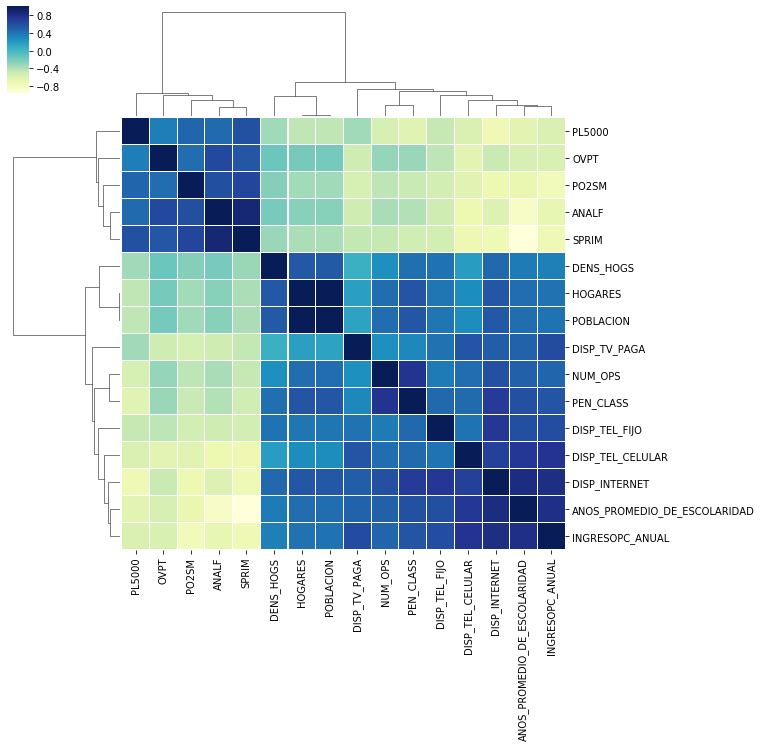

In [5]:
corrmat = data.corr() 
  
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGn", linewidths = 0.1) 

#corrmat = data.corr()   
cg = sns.clustermap(corrmat, cmap ="YlGnBu", linewidths = 0.1); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
  
cg

NameError: name 'y_train' is not defined

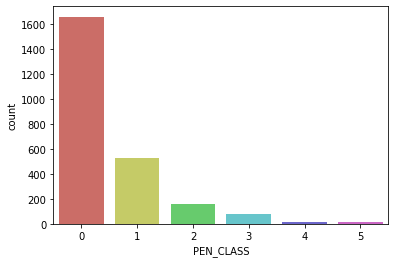

In [6]:
sns.countplot(x='PEN_CLASS',data=data,palette='hls')
data.groupby(['PEN_CLASS']).size()

def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = y_train.unique()
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    #sample_weights = [class_weight_dict[y] for y in y_train]

    return class_weight_dict #sample_weights

CreateBalancedSampleWeights(y_train, 1659/13)

#sample_weights = CreateBalancedSampleWeights(y_train, 1659/13)

### Preparamos los datos para entrenamiento y prueba

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :n-1], data.iloc[:, n-1], random_state=1)

xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)

/home/cesar/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Fitting 6 folds for each of 6 candidates, totalling 36 fits
[CV] colsample_bytree=1.0, eta=0.05, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=6, objective=multi:softmax, silent=1, subsample=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=1.0, eta=0.05, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=6, objective=multi:softmax, silent=1, subsample=1.0, total=   0.5s
[CV] colsample_bytree=1.0, eta=0.05, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=6, objective=multi:softmax, silent=1, subsample=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  colsample_bytree=1.0, eta=0.05, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=6, objective=multi:softmax, silent=1, subsample=1.0, total=   0.7s
[CV] colsample_bytree=1.0, eta=0.05, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=6, objective=multi:softmax, silent=1, subsample=1.0 
[CV]  colsample_bytree=1.0, eta=0.05, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=6, objective=multi:softmax, silent=1, subsample=1.0, total=   0.7s
[CV] colsample_bytree=1.0, eta=0.05, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=6, objective=multi:softmax, silent=1, subsample=1.0 
[CV]  colsample_bytree=1.0, eta=0.05, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=6, objective=multi:softmax, silent=1, subsample=1.0, total=   0.4s
[CV] colsample_bytree=1.0, eta=0.05, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=6, objective=multi:softmax, silent=1, subsample=1.0 
[CV]  colsample_bytree=1.0, eta=0.05,

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   18.4s finished


Accuracy: 0.8464052287581699
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       430
           1       0.68      0.71      0.69       126
           2       0.44      0.65      0.53        31
           3       0.52      0.55      0.54        20
           4       0.50      0.33      0.40         3
           5       0.25      0.50      0.33         2

    accuracy                           0.85       612
   macro avg       0.56      0.61      0.57       612
weighted avg       0.86      0.85      0.85       612



Text(91.68, 0.5, 'Valor real')

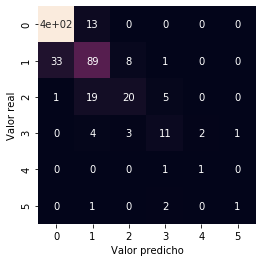

In [33]:
from sklearn.model_selection import GridSearchCV

# Instanciamos el clasificador
classifier_xgb = xgb.XGBClassifier() 

# Hyper parametros para hacer el grid search
hyper_param_grid = {
    'objective':['multi:softmax'],
    'eta':[0.05,0.06], # Tasa de aprendizaje
    'gamma': [0.5],
    'max_depth':[6,7,8],
    'subsample':[0.8],
    'silent':[1],
    'nthread':[10],
    'num_class':[6],
    'subsample':[1.0],
    'colsample_bytree':[1.0],
    'n_estimators': [10], #number of trees, change it to 1000 for better results
    #'sample_weight':[sample_weights]
    }

grid_search_xgb = GridSearchCV(classifier_xgb, hyper_param_grid, cv = 6, verbose = 2)

grid_search_xgb.fit(X_train, y_train)


y_model_xgb = grid_search_xgb.predict(X_test)
## Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(y_test, y_model_xgb)))

## Métricas clasicas de Clasificadores
from sklearn import metrics
print(metrics.classification_report(y_model_xgb, y_test))

## Matriz de confusión
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_model_xgb)

plt.close()

sns.heatmap(mat, square = True, annot = True, cbar = False)
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')


In [29]:
from xgboost import plot_importance
plot_importance(classifier_xgb)
pyplot.show()



XGBoostError: need to call fit or load_model beforehand

### Parámetros para xgboost

In [135]:
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.8
param['gamma'] = 0.5
param['max_depth'] = 8
subsample=0.8,
param['silent'] = 1
param['nthread'] = 10
param['num_class'] = 6
param['subsample'] = 1.0
param['colsample_bytree'] = 1.0
param['sample_weight']=sample_weights

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 50


### Entrenamiento y evaluación de predicciones

In [109]:
bst = xgb.train(param, xg_train, num_round, watchlist)
# get prediction
pred = bst.predict(xg_test)
error_rate = np.sum(pred != y_test) / y_test.shape[0]
print('Test error using softmax = {}'.format(error_rate))

# do the same thing again, but output probabilities
param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist)

# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
pred_prob = bst.predict(xg_test).reshape(y_test.shape[0], 6)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != y_test) / y_test.shape[0]
print('Test error using softprob = {}'.format(error_rate))

[0]	train-merror:0.068157	test-merror:0.174837
[1]	train-merror:0.055616	test-merror:0.176471
[2]	train-merror:0.032715	test-merror:0.171569
[3]	train-merror:0.026718	test-merror:0.163399
[4]	train-merror:0.015812	test-merror:0.166667
[5]	train-merror:0.006543	test-merror:0.166667
[6]	train-merror:0.003817	test-merror:0.165033
[7]	train-merror:0.001636	test-merror:0.166667
[8]	train-merror:0.001636	test-merror:0.161765
[9]	train-merror:0.001091	test-merror:0.161765
[10]	train-merror:0.001091	test-merror:0.165033
[11]	train-merror:0.001091	test-merror:0.168301
[12]	train-merror:0.001091	test-merror:0.168301
[13]	train-merror:0.001091	test-merror:0.166667
[14]	train-merror:0.001091	test-merror:0.168301
[15]	train-merror:0.001091	test-merror:0.168301
[16]	train-merror:0.001091	test-merror:0.168301
[17]	train-merror:0.001091	test-merror:0.168301
[18]	train-merror:0.001091	test-merror:0.168301
[19]	train-merror:0.001091	test-merror:0.168301
[20]	train-merror:0.001091	test-merror:0.168301
[2

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       409
           1       0.67      0.63      0.65       131
           2       0.65      0.58      0.61        45
           3       0.67      0.57      0.62        21
           4       0.00      0.00      0.00         2
           5       1.00      0.25      0.40         4

    accuracy                           0.84       612
   macro avg       0.65      0.50      0.53       612
weighted avg       0.83      0.84      0.83       612



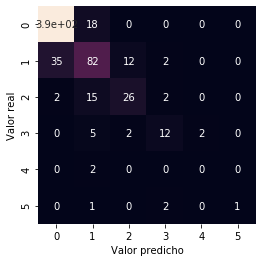

In [110]:
## Matriz de confusión
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, pred)

plt.close()

sns.heatmap(mat, square = True, annot = True, cbar = False)
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

from sklearn import metrics
print(metrics.classification_report(y_test, pred))

### Random forests

Accuracy: 0.8398692810457516
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       409
           1       0.66      0.70      0.68       125
           2       0.64      0.54      0.59        54
           3       0.67      0.64      0.65        22
           4       0.00      0.00      0.00         1
           5       0.25      1.00      0.40         1

    accuracy                           0.84       612
   macro avg       0.53      0.63      0.54       612
weighted avg       0.84      0.84      0.84       612



Text(91.68, 0.5, 'Valor real')

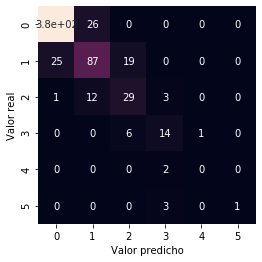

In [34]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000,criterion='entropy',max_depth=7,class_weight='balanced')
model.fit(X_train, y_train)
y_model = model.predict(X_test)

## Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(y_test, y_model)))

## Métricas clasicas de Clasificadores
from sklearn import metrics
print(metrics.classification_report(y_model, y_test))

## Matriz de confusión
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_model)

plt.close()

sns.heatmap(mat, square = True, annot = True, cbar = False)
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

Fitting 6 folds for each of 6 candidates, totalling 36 fits
[CV] criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, n_estimators=10, warm_start=TRUE 
[CV]  criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, n_estimators=10, warm_start=TRUE, score=0.825, total=   0.1s
[CV] criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, n_estimators=10, warm_start=TRUE 
[CV]  criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, n_estimators=10, warm_start=TRUE, score=0.857, total=   0.1s
[CV] criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, n_estimators=10, warm_start=TRUE 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, n_estimators=10, warm_start=TRUE, score=0.850, total=   0.1s
[CV] criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, n_estimators=10, warm_start=TRUE 
[CV]  criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, n_estimators=10, warm_start=TRUE, score=0.852, total=   0.1s
[CV] criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, n_estimators=10, warm_start=TRUE 
[CV]  criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, n_estimators=10, warm_start=TRUE, score=0.842, total=   0.1s
[CV] criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, n_estimators=10, warm_start=TRUE 
[CV]  criterion=entropy, max_depth=12, max_features=2, min_samples_split=2, n_estimators=10, warm_start=TRUE, score=0.848, total=   0.1s
[CV] criterion=entropy, max_depth=12, max_features=2, min_samples_split=5, n_estimators=10, warm_start=TRUE 
[CV]  criterion=

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    3.6s finished


Text(91.68, 0.5, 'Valor real')

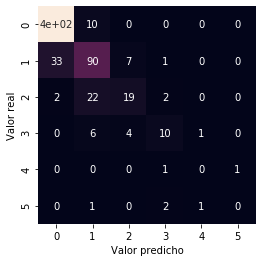

In [35]:
#np.where(np.isnan(data))
from sklearn.model_selection import GridSearchCV
classifier = RandomForestClassifier() 
hyper_param_grid = {'n_estimators': [10],#[1,10,100,1000,10000], 
                    'max_depth': [12],#5,10,20,50,100], 
                    'max_features': [2,4],#['sqrt','log2'],
                    'min_samples_split': [2,5,10],
                    'criterion':['entropy'],
                    #'class_weight':['balanced'],
                    'warm_start' :['TRUE']
                   },


grid_search = GridSearchCV(classifier, hyper_param_grid, cv = 6, verbose = 3)
grid_search.fit(X_train, y_train)

#grid_search.best_params_
#grid_search.best_score_

y_model_forest = grid_search.predict(X_test)

## Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(y_test, y_model_forest)))

## Métricas clasicas de Clasificadores
from sklearn import metrics
print(metrics.classification_report(y_model_forest, y_test))

## Matriz de confusión
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_model_forest)

plt.close()

sns.heatmap(mat, square = True, annot = True, cbar = False)
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

In [125]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 12,
 'max_features': 16,
 'min_samples_split': 5,
 'n_estimators': 100,
 'warm_start': 'TRUE'}

### Naive Bayes

Accuracy: 0.7924836601307189
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       408
           1       0.63      0.61      0.62       135
           2       0.51      0.61      0.55        38
           3       0.57      0.48      0.52        25
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         3

    accuracy                           0.79       612
   macro avg       0.44      0.43      0.43       612
weighted avg       0.79      0.79      0.79       612



Text(91.68, 0.5, 'Valor real')

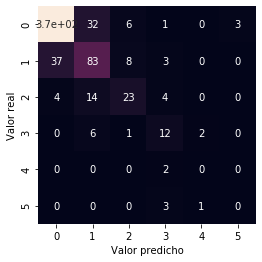

In [36]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
model_gnb = gnb.fit(X_train, y_train)
y_model_gnb = model_gnb.predict(X_test)

## Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(y_test, y_model_gnb)))

## Métricas clasicas de Clasificadores
from sklearn import metrics
print(metrics.classification_report(y_model_gnb, y_test))

## Matriz de confusión
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_model_gnb)

plt.close()

sns.heatmap(mat, square = True, annot = True, cbar = False)
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')


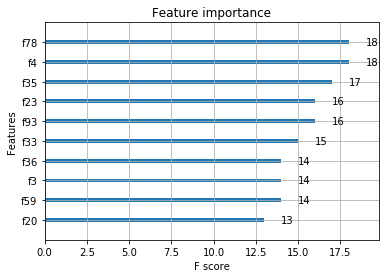

In [24]:
# generate some random data for demonstration purpose, use your original dataset here
X = np.random.rand(1000,100)     # 1000 x 100 data
y = np.random.rand(1000).round() # 0, 1 labels

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
seed=0
test_size=0.30
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=seed)
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(model, max_num_features=10) # top 10 most important features
plt.show()